In [1]:
import cv2
import dlib
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import os
import math

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmarks = [[],[]] #here we will get the corresponding points at each face
current_image_index = 0 

In [3]:
def mouse_clickback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Check if the click is on the left or right side of the concatenated image
        if x < start.shape[1]:
            # Click on the left image
            landmarks[0].append((x, y))
            print('LANDMARK 0', (x,y))
            cv2.circle(start, (x, y), 4, (0, 0, 255), -1)
            print("here")
        else:
            # Click on the right image
            landmarks[1].append((x - start.shape[1], y))
            print('LANDMARK 1', (x - start.shape[1],y))
            cv2.circle(end, (x - start.shape[1], y), 4, (0, 0, 255), -1)
            print("here")

In [4]:
start = cv2.imread("jamie.jpg")
start = cv2.resize(start, (600, 500))
gray_start = cv2.cvtColor(start, cv2.COLOR_BGR2GRAY)

end = cv2.imread("jenna.jpg")
end = cv2.resize(end, (600, 500))
gray_end = cv2.cvtColor(end, cv2.COLOR_BGR2GRAY)

h, w = gray_start.shape
print(w)
(500,600)

manual_landmarks_0 = [(319, 24), (246, 37), (193, 89), (179, 138), (381, 48), (415, 96)]
manual_landmarks_1 = [(328, 20), (265, 40), (230, 81), (212, 146), (388, 58), (416, 137)]

    
w_space = np.linspace(0, 600, num = 10)
for w in w_space:
    landmarks[0].append((w,0))
    landmarks[0].append((w,500))
    landmarks[1].append((w,0))
    landmarks[1].append((w,500))

    
h_space = np.linspace(0, 500, num = 10)
for h in h_space:
    landmarks[0].append((0,h))
    landmarks[0].append((600,h))
    landmarks[1].append((0,h))
    landmarks[1].append((600,h))

landmarks[0].append((0, 0))             # Top-left corner
landmarks[0].append((w - 1, 0))         # Top-right corner
landmarks[0].append((0, h - 1))         # Bottom-left corner
landmarks[0].append((w - 1, h - 1))

# Add four corners as landmarks for the second image
h, w = gray_end.shape
landmarks[1].append((0, 0))             # Top-left corner
landmarks[1].append((w - 1, 0))         # Top-right corner
landmarks[1].append((0, h - 1))         # Bottom-left corner
landmarks[1].append((w - 1, h - 1))


for point in manual_landmarks_0:
    landmarks[0].append(point)

for point in manual_landmarks_1:
    landmarks[1].append(point)

# detect the faces
rects = detector(gray_start)

#go through face rects
for rect in rects:
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom()
    
    cv2.rectangle(start, (x1, y1), (x2, y2), (0,255,0), 3)
    
    #apply shape predictor
    shape = predictor(gray_start, rect)
    
    for n in range(0,68):
        x = shape.part(n).x
        y = shape.part(n).y
        landmarks[0].append((x,y))
        cv2.circle(start, (x,y), 4, (255, 0, 0), -1)

end_rects = detector(gray_end)


for rect in end_rects:
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom()
    
    cv2.rectangle(end, (x1, y1), (x2, y2), (0,255,0), 3)
    shape = predictor(gray_end, rect)
    
    # landmarks[1] = [(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)]
    
    for i in range(0, 68):
        x = shape.part(i).x
        y = shape.part(i).y
        
        landmarks[1].append((x,y))
        cv2.circle(end, (x,y), 4, (255, 0, 0), -1)
        
result = cv2.hconcat([start, end])

cv2.imshow("Corresponding face values", result)

cv2.setMouseCallback("Corresponding face values", mouse_clickback)


# Wait for user input
cv2.waitKey(0)



600


100

118


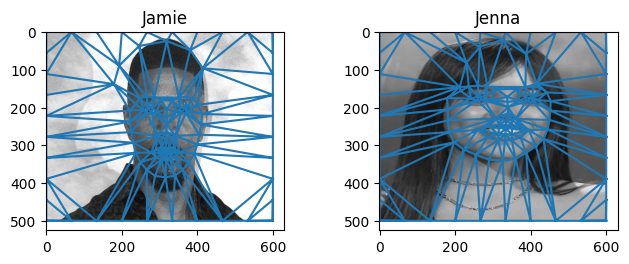

In [5]:
firstImg = np.array(landmarks[0])
secondImg = np.array(landmarks[1])

print(len(landmarks[0]))



firstTri = Delaunay(firstImg)

firstTriList = firstImg[firstTri.simplices]
secondTriList = secondImg[firstTri.simplices]

plt.subplot(1,2,1)
plt.imshow(gray_start, cmap='gray')
plt.triplot(firstImg[:,0], firstImg[:,1], firstTri.simplices) 
plt.title("Jamie")


plt.subplot(1,2,2)
plt.imshow(gray_end, cmap='gray')
plt.triplot(secondImg[:,0], secondImg[:,1], firstTri.simplices)
plt.title("Jenna")

plt.tight_layout()

plt.subplots_adjust(wspace=0.4)

plt.show()

In [6]:
def intermediate_coords(trig1, trig2, alpha):
    #return the intermediate co-ordinates between two triangles depending
    #on the value of alpha 
    return ((trig2 - trig1) * alpha) + trig1

In [7]:
def affine_transformation_new(intermediate_triangle, triangle):
    #works out paraeters
    A1, B1, C1 = triangle[0], triangle[1], triangle[2]
    A2, B2, C2 = intermediate_triangle[0], intermediate_triangle[1], intermediate_triangle[2]
    
    A = np.array([
            [A1[0], A1[1], 1, 0, 0, 0],
            [0, 0, 0, A1[0], A1[1], 1],
            [B1[0], B1[1], 1, 0, 0, 0],
            [0, 0, 0, B1[0], B1[1], 1],
            [C1[0], C1[1], 1, 0, 0, 0],
            [0, 0, 0, C1[0], C1[1], 1],
        ])
    B = np.array([A2[0], A2[1], B2[0], B2[1], C2[0], C2[1]])
    a, b, c, d, e, f = np.linalg.solve(A,B)
    
    T = np.array([ 
        [a, b, c], 
        [d, e, f], 
        [0, 0, 1],
    ])
    T_inv = np.linalg.inv(T)
    
    return T_inv
        

In [9]:
def bilinear_interpolation(img, x, y):
    height, width = img.shape[:2]
    
    x0, y0 = np.floor(x).astype(int), np.floor(y).astype(int)
    x1, y1 = np.ceil(x).astype(int), np.ceil(y).astype(int)
    
    x0 = np.clip(x0, 0, width - 1)
    y0 = np.clip(y0, 0, height - 1)
    x1 = np.clip(x1, 0, width - 1)
    y1 = np.clip(y1, 0, height - 1)
    
    Q11 = img[y0, x0]
    Q21 = img[y0, x1]
    Q12 = img[y1, x0]
    Q22 = img[y1, x1]
    
    x_weight = x - x0
    y_weight = y - y0

    interpolated_value = (1 - x_weight) * (1 - y_weight) * Q11 + \
                         x_weight * (1 - y_weight) * Q21 + \
                         (1 - x_weight) * y_weight * Q12 + \
                         x_weight * y_weight * Q22

    return interpolated_value

In [10]:
def is_point_inside_triangle(x, y, triangle):

    x1, y1 = triangle[0]
    x2, y2 = triangle[1]
    x3, y3 = triangle[2]

    # Compute barycentric coordinates
    detT = (y2 - y3) * (x1 - x3) + (x3 - x2) * (y1 - y3)
    if detT == 0:
        return False

    alpha = ((y2 - y3) * (x - x3) + (x3 - x2) * (y - y3)) / detT
    beta = ((y3 - y1) * (x - x3) + (x1 - x3) * (y - y3)) / detT
    gamma = 1 - alpha - beta

    # Check if the points are inside the triangle
    return 0  <= alpha <= 1 and 0 <= beta <= 1 and 0 <= gamma <= 1

In [11]:
def mapPoints(triangle):
    within = []
    
    triangleX = np.sort(triangle[:,0])
    triangleY = np.sort(triangle[:,1])
    
    x_s,x_b, y_s, y_b = triangleX[0], triangleX[2], triangleY[0], triangleY[2]
    #creates a bounding box between the smallest and largest values in the vertices
    x_s,x_b, y_s, y_b = np.floor(x_s), np.ceil(x_b), np.floor(y_s), np.ceil(y_b)
    
    #iterate over the bounding box and checks to see if a point is in the triangle each time
    for i in range(int(x_s) - 1, int(x_b) + 1):
        #ensure it checks for edges 
        for pointer in range(int(y_s) - 1, int(y_b) + 1):
            if(is_point_inside_triangle(i +.5, pointer +.5, triangle)):
                within.append([i +.5, pointer +.5])
    return np.array(within).astype(int)
    

In [ ]:
numImages = 50
w = np.linspace(0, 1, num = numImages)


def perform_transformation(firstImg, secondImg, numImages, w, gray_start, gray_end):
    intermediate_image = []
    
    for step in w:
        intermediate_frame = np.zeros_like(gray_start, dtype=np.uint8)
        #get the intermediate_points between both landmarks
        intermediate_points = intermediate_coords(firstImg, secondImg, step)
        triangulation = intermediate_points[firstTri.simplices]
        
        firstImg_triangulation = firstImg[firstTri.simplices]
        secondImg_triangulation = secondImg[firstTri.simplices]
        
        for idx, intermediateTriangle in enumerate(triangulation):
        
            firstTransformation = affine_transformation_new(intermediateTriangle, firstImg_triangulation[idx])
            secondTransformation = affine_transformation_new(intermediateTriangle, secondImg_triangulation[idx])
            
            trianglePoints = mapPoints(intermediateTriangle)
            for point in trianglePoints:
                x, y = point
                point = np.array([x,y,1])
                
                x1, y1, _ = np.dot(firstTransformation, point)
                x2, y2, _ = np.dot(secondTransformation, point)
                
                intensity_start = bilinear_interpolation(gray_start, x1 ,y1)
                intensity_end = bilinear_interpolation(gray_end, x2, y2)
                
                blended_intensity = (1-step) * intensity_start + step * intensity_end 
                
                intermediate_frame[y,x] = blended_intensity
        intermediate_image.append(intermediate_frame)
        
    return intermediate_image
                
intermediate_image = perform_transformation(firstImg, secondImg, numImages, w, gray_start, gray_end)
print("done")

KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np

def save_frame(frame, frame_path):
    # Assuming frame is a numpy array
    cv2.imwrite(frame_path, frame)

def create_video(frames, output_folder, output_video, frame_rate=10):
    os.makedirs(output_folder, exist_ok=True)

    height, width = frames[0].shape
    size = (width, height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI format
    out = cv2.VideoWriter(output_video, fourcc, frame_rate, size)

    for i, frame in enumerate(frames):
        frame_filename = f'frame_{i:03d}.png'
        frame_path = os.path.join(output_folder, frame_filename)

        # Save the frame with proper Unicode encoding
        save_frame(frame, frame_path)

        # Read the saved image and write to the video
        img = cv2.imread(frame_path)
        out.write(img)

    out.release()

    print(f"Video saved at: {output_video}")

In [ ]:
create_video(intermediate_image, output_folder='output_frames2', output_video='output_video.mp4')